# Variant Call Adjacency Matrix


An interconnected matrix of variants from data in 1000 genomes.


# GA4GH Server Connection Established

Here, like the 1kg example, a client object is used to communicate with the server.

In [1]:
from __future__ import print_function
import ga4gh.client as client
data = client.HttpClient("http://1kgenomes.ga4gh.org")

import collections
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.axes_grid1 import ImageGrid
#import Figtodat
#from images2gif import writeGif

# Data Sets 

In [2]:
datasets = list(data.searchDatasets())
print("Datasets")
for dataset in datasets:
    print("Name: {}".format(dataset.name))

Datasets
Name: 1kgenomes


In [3]:
dataset = data.getDataset(datasets[0].id)

In [4]:
release = None
functional = None
for variantSet in data.searchVariantSets(datasetId=dataset.id):
    if variantSet.name == "phase3-release":
        release = variantSet
    else:
        functional = variantSet

In [5]:
callsi = list(data.searchCallSets(release.id))

variantSets = list(data.searchVariantSets(dataset.id))
variantSetId = variantSets[0].id

call_set_ids = []

for csi in callsi:        
    call_set_ids.append(csi.id)

# generate_dictionary function

generates a dictionary of call set id keys and values for the index of that the call set id appeared throughout a list of variants within a given range on the human genome

In [6]:
def generate_dictionary(num_people, num_chrom, begin, stop):
    
    #x = data.searchVariants(variantSetId, start=begin, end=stop, 
    #referenceName = num_chrom).next()
      
    dictionary = {}
    
    variants = data.searchVariants(variantSetId, callSetIds= call_set_ids[0:num_people],
           start=begin, end=stop, referenceName = num_chrom )
    
    i = 0
    for v in variants:
        for call_inner in v.calls:
            i += 1
            dictionary[call_inner.call_set_id] = i
    
    return (dictionary)  

# normalize_indexes function

initializes the indexes of the variant dictionay to be {0,...,n} where n is the number of call set ids 

In [7]:
def normalize_indexes(dictionary):
       
    keys = []
    keys = dictionary.keys()
    
    new_dictionary = {}
    i = 0
    j = 0
    k = 0
    for i in range(len(dictionary)):        
        l = keys[j]
        dictionary[l] = k
        j += 1
        k += 1
    
    return dictionary

In [8]:
dictionary = generate_dictionary(40, "1", 100000, 105000 )
#print()
normalize_indexes(dictionary)

{u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDA5NiJd': 20,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDA5NyJd': 14,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDA5OSJd': 8,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDE0MCJd': 17,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwMCJd': 27,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwMSJd': 15,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwMiJd': 34,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwMyJd': 38,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwNSJd': 30,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwNiJd': 5,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwNyJd': 1,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwOCJd': 32,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwOSJd': 6,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDExMCJd': 36,
 u'WyIxa2dlbm9tZXMiLCJ2c

# variant_matrix function

This function connects two identical sets of participant sample's callSetId's through the variants shared between them.

                     M D (Mother/Father allele donated)
    Where A or B =  [1,0] : heterozygous for variant
                    [0,1] : heterozygous for variant
                    [1,1] : homozygous dominant for variant
                    [0,0] : homozygous recessive for variant
                 
        | 1    |  0    |
      1 |[1,1] | [1,0] |
        |      |       |      
      0 |[1,0] | [0,0] |
    
    
    True for the shared genotype:
        
        case 1: 
            A = [1,0]
            B = [0,1]
        case 2: 
            A = [0,0]
            B = [0,0]
        case 3:  
            A = [1,0]
            B = [1,0]
        case 4: 
            A = [1,1]
            B = [0,1]
    
    False for the shared genotype:
        
        case 1: 
            A = [1,0]
            B = [0,0]
        case 2:
            A = [0,1]
            B = [0,0]
        case 3: 
            A = [0,0]
            B = [1,0]
        case 4:
            A = [0,0]
            B = [0,1]
            
            

In [9]:
def variant_matrix(callMatrix, num_people, num_chrom, begin, stop):
#def variant_matrix(callMatrix):
        
    csid_dict = {}    
    csid_dict = generate_dictionary(num_people, num_chrom, begin, stop)
    
    normalize_indexes(csid_dict)
    
    h = len(csid_dict)
    w = len(csid_dict)
    dimension = h*w
    
    callMatrix = [[0 for x in range(w)] for y in range(h)]    
    np.zeros((h,w))     
    #np.reshape(callMatrix, (h,w))
    
    vs = data.searchVariants(variantSetId, callSetIds= call_set_ids[0:num_people],
           start=begin, end=stop, referenceName = num_chrom)

    for v in vs:
        for call_outer in v.calls:         
            for call_inner in v.calls:               
                outer_index = csid_dict[call_outer.call_set_id] 
                inner_index = csid_dict[call_inner.call_set_id]                             
                # can be 0 or 1
                A1 = call_outer.genotype[0] 
                A2 = call_outer.genotype[1]
                B1 = call_inner.genotype[0]
                B2 = call_inner.genotype[1]               
                # True for the shared genotype
                if (((A1 + A2 ) > 0) and ((B1 + B2) > 0)):
                    callMatrix[outer_index][inner_index] += 1
                elif (((A1 + A2 ) == 0) and ((B1 + B2) == 0)):
                    callMatrix[outer_index][inner_index] += 1               
                
    return (callMatrix)

In [10]:
matrix = {}
variant_matrix(matrix, 10, "1", 100000, 140000)

[[193, 190, 191, 189, 189, 191, 190, 190, 190, 190],
 [190, 193, 192, 192, 192, 192, 193, 193, 193, 191],
 [191, 192, 193, 191, 191, 193, 192, 192, 192, 192],
 [189, 192, 191, 193, 193, 191, 192, 192, 192, 190],
 [189, 192, 191, 193, 193, 191, 192, 192, 192, 190],
 [191, 192, 193, 191, 191, 193, 192, 192, 192, 192],
 [190, 193, 192, 192, 192, 192, 193, 193, 193, 191],
 [190, 193, 192, 192, 192, 192, 193, 193, 193, 191],
 [190, 193, 192, 192, 192, 192, 193, 193, 193, 191],
 [190, 191, 192, 190, 190, 192, 191, 191, 191, 193]]

# visualize_matrix function 

In [15]:
def visualize_matrix_color(callMatrix, num_people, num_chrom, begin, stop):
    
    callMatrix = variant_matrix(callMatrix, num_people, num_chrom, begin, stop)
    
    #callMatrix = callMatrix.squeeze()
    
    fig = plt.figure(1,(10.,10.))
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(1,1),
                    axes_pad=0.1)
    
    ax = grid[0]
    ax.set_title('Color matrix comparing the occurence of shared variants obtained from call set ids between individuals in the the genomic dataset\n', fontsize=14, fontweight='bold')
    ax.set_xlabel("Individual's call set ids", fontsize=12)
    ax.set_ylabel("Individual's call set ids", fontsize=12)    
    ax.imshow(callMatrix, origin = "lower", interpolation="nearest")
    
    plt.show()

def visualize_matrix_grey(callMatrix, num_people, num_chrom, begin, stop):
    
    callMatrix = variant_matrix(callMatrix, num_people, num_chrom, begin, stop)
      
    #print(np.asarray(callMatrix).shape[0])
    
    fig = plt.figure(1,(10.,10.))
   
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(1,1),
                    axes_pad=0.1)
    ax = grid[0]  
    ax.set_title('Greyscale matrix comparing the occurence of shared variants obtained from call set ids between individuals in the the genomic dataset\n', fontsize=14, fontweight='bold')
    ax.set_xlabel("Individual's call set ids", fontsize=12)
    ax.set_ylabel("Individual's call set ids", fontsize=12)
    
    ax.imshow(callMatrix, cmap= 'Greys', origin = "lower", interpolation="nearest")
    
 
    plt.show()

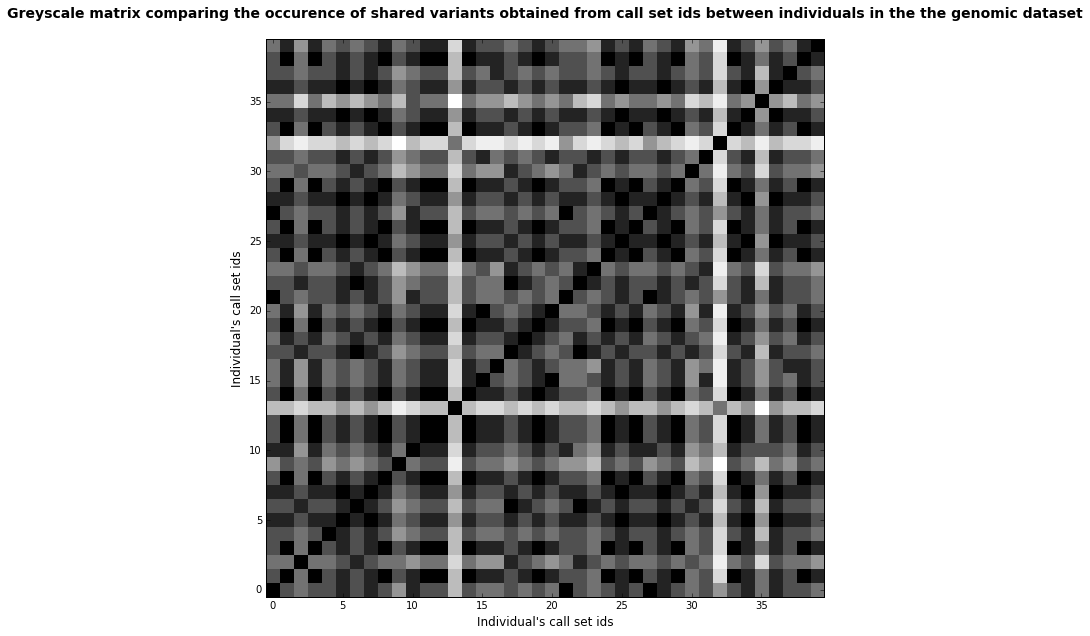

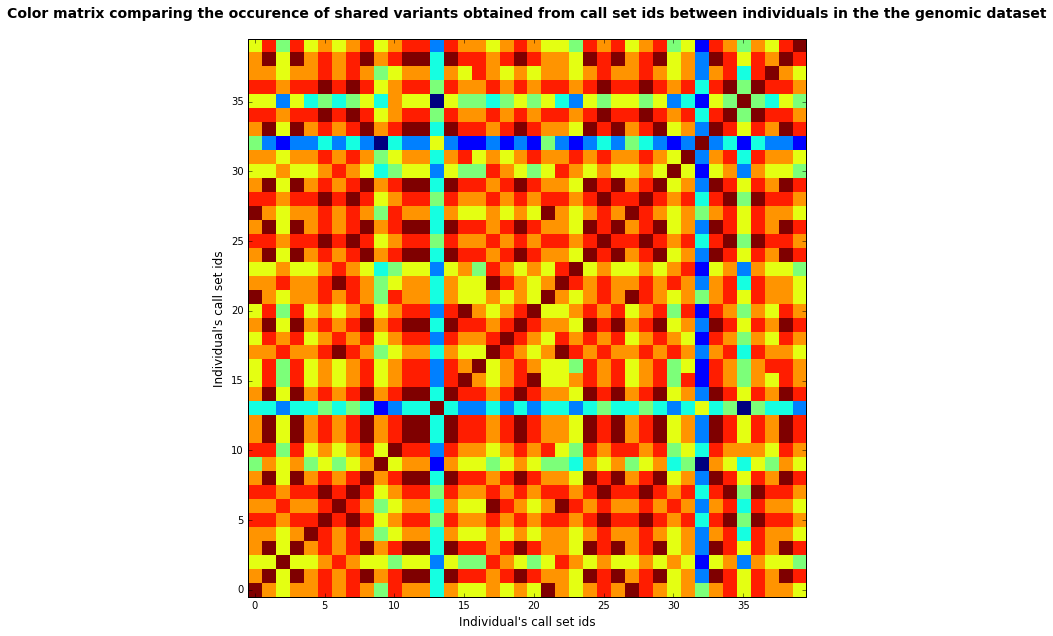

In [16]:

'''
i = 100000
j = 105000
while ( i != j):
    matrix = {}
    visualize_matrix_grey(matrix, 5, "1", i, j)
    i += 5000
    j += 5000
    if ( j == 300000 and i == 205000): break

visualize_matrix_grey(matrix, 500, "1", 100000, 105000)
visualize_matrix_grey(matrix, 500, "1", 105000, 110000)
visualize_matrix_grey(matrix, 500, "1", 110000, 115000)
visualize_matrix_grey(matrix, 500, "1", 115000, 120000)
visualize_matrix_grey(matrix, 500, "1", 120000, 125000)
visualize_matrix_grey(matrix, 500, "1", 125000, 130000)
visualize_matrix_grey(matrix, 500, "1", 130000, 135000)
visualize_matrix_grey(matrix, 500, "1", 135000, 140000)
#visualize_matrix_grey(matrix, 40, "1", 140000, 145000) #TypeError: Invalid dimensions for image data
visualize_matrix_grey(matrix, 500, "1", 145000, 150000)
visualize_matrix_grey(matrix, 500, "1", 150000, 155000)
visualize_matrix_grey(matrix, 500, "1", 155000, 160000)
#visualize_matrix_grey(matrix, 40, "1", 160000, 165000) TypeError: Invalid dimensions for image data
visualize_matrix_grey(matrix, 500, "1", 165000, 170000)
visualize_matrix_grey(matrix, 500, "1", 170000, 175000)
#visualize_matrix_grey(matrix, 40, "1", 175000, 180000) TypeError: Invalid dimensions for image data
#visualize_matrix_grey(matrix, 40, "1", 180000, 185000) TypeError: Invalid dimensions for image data
#visualize_matrix_grey(matrix, 40, "1", 185000, 190000) TypeError: Invalid dimensions for image data
#visualize_matrix_grey(matrix, 40, "1", 190000, 195000) TypeError: Invalid dimensions for image data
#visualize_matrix_grey(matrix, 40, "1", 195000, 200000) TypeError: Invalid dimensions for image data
'''
matrix = {}
visualize_matrix_grey(matrix, 40, "1", 100000, 140000)
matrix = {}
visualize_matrix_color(matrix, 40, "1", 100000, 140000)



In [17]:
def determine_matrix_range():
    
    matrix = {}
    matrix = variant_matrix(matrix, 40, "1", 100000, 140000)
    
    i = 0
    j = 0
    cur = 0
    lis = []
    
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            cur = matrix[i][j]
            lis.append(cur)
            
    minimum = min(lis)
    maximum = max(lis)
    print ("values in the matrix range from {} to {}".
           format(minimum, maximum))
    lis.sort()

    return lis

In [18]:
#determine_matrix_range()

In [19]:
def find_percent_occurence():
    
    matrix_list = []
    matrix_list = determine_matrix_range()   
    i = 0
    key_list = []
    j = 0
    for i in matrix_list:
        variable = matrix_list[j]
        if (variable == i):
            key_list.append(variable)
            j += 1
        elif ( variable != i):
            j += 1
            
    occur_dict = {}
    occur_dict = occur_dict.fromkeys(key_list,0)
    i = 0
    j = 0  
    total = 0.0
    for i in matrix_list:
        variable = matrix_list[j]
        if ( i == variable):
            occur_dict[i] += 1
            j += 1
        elif ( i != variable):
            j += 1
        total += 1
    
    percent = 0.0
    for i in occur_dict:
        percent = ((occur_dict[i]/total)*100.0)
        occur_dict[i] = percent
    
    return occur_dict


In [20]:
#find_percent_occurence()

In [21]:
def graph_percent_occurence():
    
    fig = plt.figure(1,(9.,9.))
    
    occur_dict = {}
    occur_dict = find_percent_occurence()
    
    occur_dict = collections.OrderedDict(sorted(occur_dict.items()))
    
    plt.bar(range(len(occur_dict)), occur_dict.values(), align='center')
    plt.xticks(range(len(occur_dict)), occur_dict.keys())
    
    ax = fig.add_subplot(111)
    ax.set_title('Distribution of shared variants among the genomic dataset (as compared to the reference genome)\n', fontsize=14, fontweight='bold')
    ax.set_xlabel('number of shared variants called within a range of bases on one chromosome')
    ax.set_ylabel('percent occurence of the amount of shared variants')
    plt.show()
    

values in the matrix range from 185 to 193


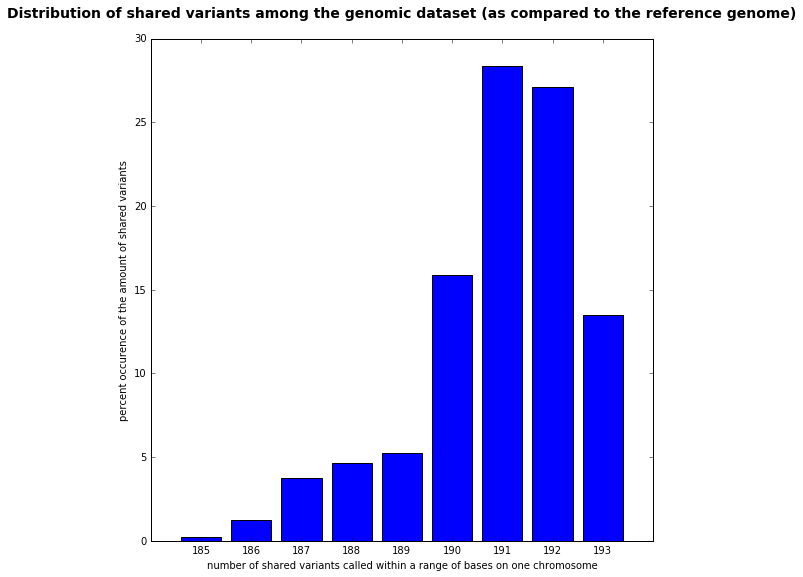

In [22]:
graph_percent_occurence()